In [17]:
%reload_ext autoreload
%autoreload 2

In [18]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import glob
import json
import pandas as pd
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [19]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [31]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            combined.append(slack_data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [32]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a)
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [22]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [45]:
import glob
import json
import pandas as pd
import os

def slack_parser(base_path):
    all_data = []

    # Iterate over each channel directory
    for channel_dir in glob.glob(f"{base_path}/*/"):
        channel_name = os.path.basename(os.path.normpath(channel_dir))

        # Process each JSON file in the channel directory
        for json_file in glob.glob(f"{channel_dir}/*.json"):
            with open(json_file, 'r', encoding="utf8") as file:
                data = json.load(file)
                
                # Process each message
                for message in data:
                    # Extract relevant information
                    message_type = message.get('type', 'unknown')
                    content = message.get('text', '')
                    sender = message.get('user_profile', {}).get('real_name', 'unknown')
                    sent_time = message.get('ts', 'unknown')
                    distribution_type = 'text'  # Default to 'text', modify as needed
                    thread_start_time = message.get('thread_ts', 'unknown')
                    reply_count = message.get('reply_count', 0)
                    reply_users_count = message.get('reply_users_count', 0)
                    reply_users_list = ",".join(message.get('reply_users', []))
                    thread_end_time = message.get('latest_reply', 'unknown')

                    # Add the processed message to the list
                    processed_message = {
                        'Message Type': message_type,
                        'Content': content,
                        'Sender Name': sender,
                        'Sent Time': sent_time,
                        'Distribution Type': distribution_type,
                        'Thread Start Time': thread_start_time,
                        'Reply Count': reply_count,
                        'Reply Users Count': reply_users_count,
                        'Reply Users List': reply_users_list,
                        'Thread End Time': thread_end_time,
                        'Channel Name': channel_name
                    }
                    all_data.append(processed_message)

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    return df


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [47]:
parseddf = slack_parser('../data/anonymized/')

In [48]:
parseddf

,Message Type,Content,Sender Name,Sent Time,Distribution Type,Thread Start Time,Reply Count,Reply Users Count,Reply Users List,Thread End Time,Channel Name
0,message,<@u03u9fwpnce> has joined the channel,unknown,1661765937.810099,text,unknown,0,0,,unknown,ab_test-group
1,message,<@u03ud4fedhb> has joined the channel,unknown,1661765994.399499,text,unknown,0,0,,unknown,ab_test-group
2,message,<@u03u1hag9tr> has joined the channel,unknown,1661765994.453809,text,unknown,0,0,,unknown,ab_test-group
3,message,<@u03ug4q7v42> has joined the channel,unknown,1661765994.542189,text,unknown,0,0,,unknown,ab_test-group
4,message,"hi guys,\ni thought having a group chat would ...",Maria Martin,1661766066.863109,text,unknown,0,0,,unknown,ab_test-group
...,...,...,...,...,...,...,...,...,...,...,...
20006,message,Alejandra also,Diane Cruz,1663093203.238019,text,unknown,0,0,,unknown,week4-teamwork
20007,message,the connection is very slow,Susan Lewis,1663093633.896039,text,unknown,0,0,,unknown,week4-teamwork
20008,message,guys my network is not working,Diane Cruz,1663094118.932099,text,unknown,0,0,,unknown,week4-teamwork
20009,message,okay bro we will update you.,Catherine Campos,1663094488.880729,text,unknown,0,0,,unknown,week4-teamwork


## 1. Number of Messages per Channel

This will show which channels are most active.

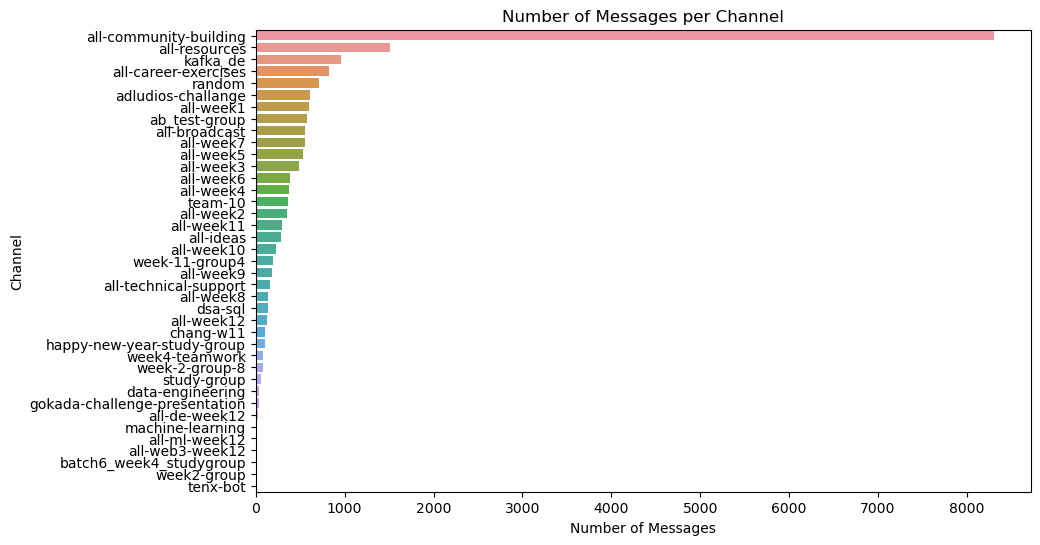

In [51]:
messages_per_channel = parsed['Channel Name'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=messages_per_channel.values, y=messages_per_channel.index)
plt.xlabel('Number of Messages')
plt.ylabel('Channel')
plt.title('Number of Messages per Channel')
plt.show()



## 2. Message Distribution Over Time
This helps to understand the activity trend over time.

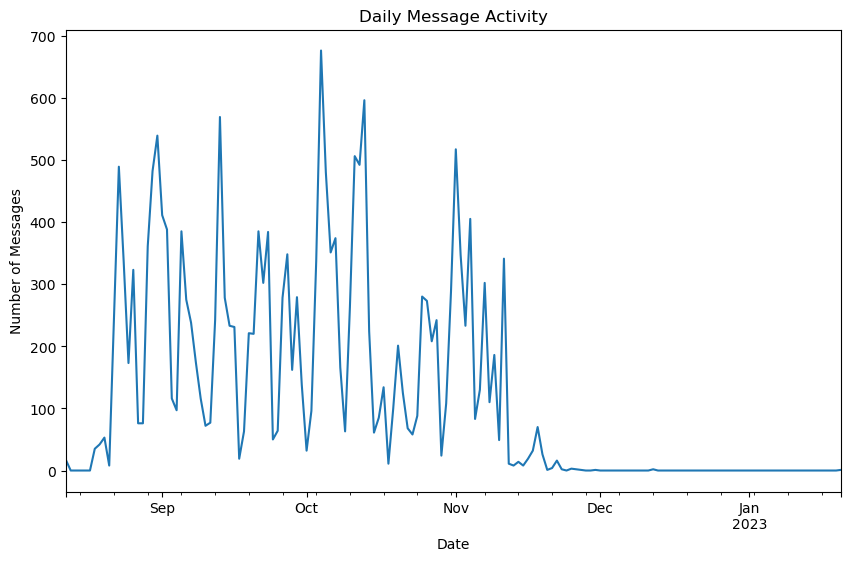

In [52]:
# Convert timestamp to datetime
parsed['Sent Time'] = pd.to_datetime(parsed['Sent Time'], unit='s')

# Resample by day (or choose 'W' for week, 'M' for month)
daily_messages = parsed.set_index('Sent Time').resample('D').size()

# Plot
plt.figure(figsize=(10, 6))
daily_messages.plot()
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.title('Daily Message Activity')
plt.show()


## 3. Replies and Participation in Threads
This can help identify the most engaging or controversial topics.

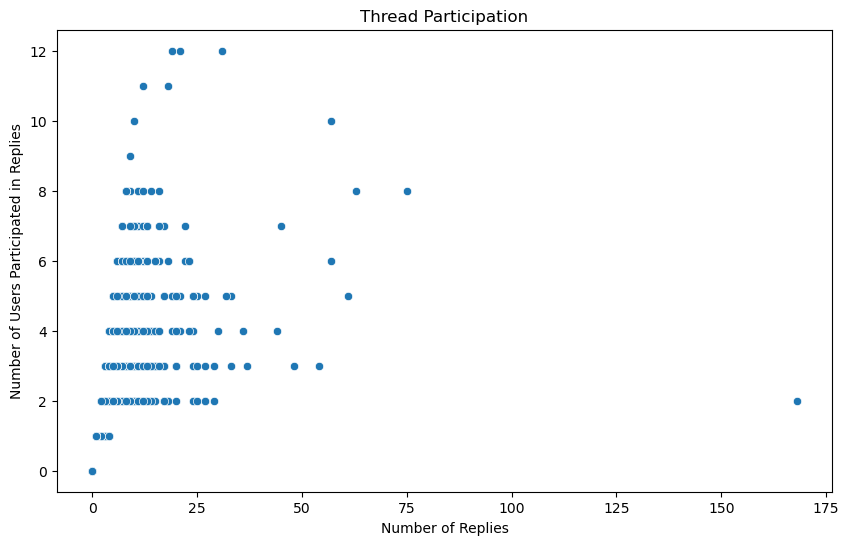

In [53]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=parsed, x='Reply Count', y='Reply Users Count')
plt.xlabel('Number of Replies')
plt.ylabel('Number of Users Participated in Replies')
plt.title('Thread Participation')
plt.show()

In [7]:
# which user has the highest number of reply counts?

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?